In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy

# from mlflow import log_metric, log_param, log_artifacts
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss

In [8]:
# print(torch.cuda.is_available())

True


In [9]:
# DEVICE = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [10]:
def set_device():
    """
    Set the device. CUDA if available, CPU otherwise

    Args:
      None

    Returns:
      Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print(
            "GPU is not enabled in this notebook. \n"
            "If you want to enable it, in the menu under `Runtime` -> \n"
            "`Hardware accelerator.` and select `GPU` from the dropdown menu"
        )
    else:
        print(
            "GPU is enabled in this notebook. \n"
            "If you want to disable it, in the menu under `Runtime` -> \n"
            "`Hardware accelerator.` and select `None` from the dropdown menu"
        )

    return device

In [11]:
def reverse_one_hot(x, neuronCats):
    a = np.zeros(len(x))
    x = torch.detach(x)
    for i in range(len(x)):
        a[i] = torch.max(x[i]) - 1 + np.argmax(x[i]) * neuronCats
    return a

def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)

In [12]:
# ------- control variables: -------
# number of categories a neuron can distinguish / parameter that determines the number of output neurons
neuronCats = 1
# number of categories per neuron, i.e. neuronCats (+ 1 for others in case of multiple Outputs)
categories = 2
# how often a classification sector occurs (1 means no periodicity)
periodicity = 1

## Load Data

In [13]:
train_csv = pd.read_csv(
    "autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [14]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(
        X, y, train_size=46806, random_state=42
    )

# one-hot encoding
numSamples, numFeatures = x_valid.shape
y_valid_int = y_valid
y2 = y_valid + 1  # auxiliary variable so that classes start at 1 and not 0
numClasses = max(y2)
target_ids = range(numClasses)
no = int(np.ceil(numClasses / neuronCats))  # number of output neurons
if no != 1:
    y_valid = torch.zeros(numSamples, no)
    for i in range(numSamples):
        k = int(np.ceil(y2[i] / neuronCats)) - 1
        c = np.mod((y2[i] - 1), neuronCats) + 1
        y_valid[i, k] = c
numSamples, numFeatures = x_train.shape
y_train_int = y_train
y2 = y_train + 1  # auxiliary variable so that classes start at 1 and not 0
if no != 1:
    y_train = torch.zeros(numSamples, no)
    for i in range(numSamples):
        k = int(np.ceil(y2[i] / neuronCats)) - 1
        c = np.mod((y2[i] - 1), neuronCats) + 1
        y_train[i, k] = c
del y2

# Convert numpy arrays into torch tensors
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
if y_train.size().__len__() == 1:
    y_train = torch.unsqueeze(y_train, 1)
    y_valid = torch.unsqueeze(y_valid, 1)

# convert angles to complex numbers on unit-circle
x_train = torch.exp(1.0j * x_train)
x_valid = torch.exp(1.0j * x_valid)

# ns = number of samples , ni = number of inputs / input neurons
ns, ni = x_train.shape

<ipython-input-15-67ce26329374>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


In [16]:
x_train = x_train
y_train = y_train
x_train.shape

torch.Size([46806, 48])

In [17]:

y_train.shape

torch.Size([46806, 11])

## Model

In [21]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity

        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act2 = cmplx_phase_activation()

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)

def train(
    model,
    X,
    y,
    epochs,
    batch_size,
    optimizer,
    criterion,
    categories,
    periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    list_weights = []
    list_bias = []
    list_outputs = []
    list_self_adjusting_learning_rate = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            xb = xb
            yb = yb

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)

            loss = criterion(y_pred, yb, categories, periodicity)
            # wandb.log({"loss": torch.abs(loss)})
            
            if i % 10 == 9: print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(sum(batch_loss)/len(batch_loss))
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

    return (
        losses,
        scores,
        list_weights,
        list_bias,
        list_outputs,
        list_self_adjusting_learning_rate,
    )

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [24]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [25]:
(
    losses,
    scores,
    list_weights,
    list_bias,
    list_outputs,
    list_self_adjusting_learning_rate,
) = train(model, x_train, y_train, epochs=100, batch_size=100, optimizer=optimizer, criterion=criterion, categories=categories, periodicity=periodicity)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

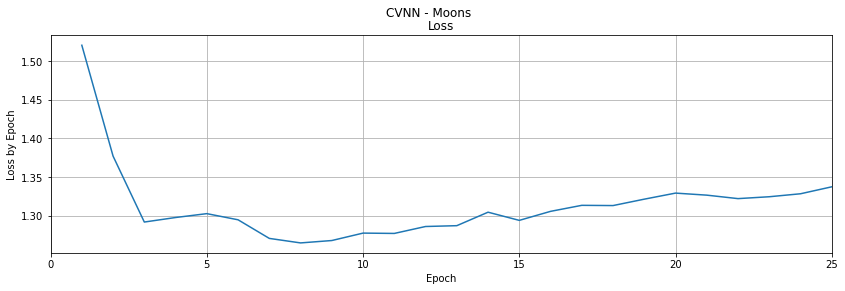

In [12]:
def plot_loss(title, losses):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss by Epoch")
    ax1.set_title("Loss")
    ax1.set_xlim(0, len(losses))


    plt.show()

plot_loss(
    "CVNN - Autass",
    losses,
    )

In [14]:
y_pred = model.predict(x_valid)

In [15]:
y_valid

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [16]:
y_pred

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64,
       grad_fn=<RemainderBackward0>)

In [17]:
acc = accuracy(y_pred.squeeze(), y_valid)
acc

0.6970007690335811